In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

In [2]:
import pandas as pd
import os
from scipy import stats
import numpy as np
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import json

In [4]:
nuw = 1 #cp
nun = 0.8 #cp
cases = json.load(open('./Data/Exp_extracted.json'))

# Get vo, vp, and vm for each curve (case)

In [5]:
for case in cases:
    krw = case['krw']
    krn = case['kro']
    sw = case['sw']
    l = len(case['sw'])
    #get vp for all points 
    vp_vo = [nuw *((i/nuw)+(j/nun)) for i, j in zip(krw,krn)] #vp/vo
    # get vm using the derivative of vp/vo
    d_vp_vo_dsw = []
    vm_vo = []
    for i in range (l):
        if i ==0: #first point, forward derivative
            d_vp_vo_i = vp_vo[i+1]- vp_vo[i]  # d(vp/vo)
            d_sw_i = sw[i+1] - sw[i] # dSw
        elif i == (l-1): #last point, backward derivative
            d_vp_vo_i = vp_vo[i]- vp_vo[i-1] 
            d_sw_i = sw[i] - sw[i-1] 
        else: # intermediate points, take the average of the forward and backward derivatives
            d_vp_vo_i = 0.5 * ((vp_vo[i+1]- vp_vo[i]) + (vp_vo[i]- vp_vo[i-1]))
            d_sw_i = 0.5 * ((sw[i+1] - sw[i]) + (sw[i] - sw[i-1]))
        d_vp_vo_dsw_i = d_vp_vo_i/d_sw_i  # d(vp/vo)/dSw
        vm_vo_i_0 = d_vp_vo_dsw_i + (nuw*((krn[i]/nun)-(krw[i]/nuw)))
        vm_vo_i = d_vp_vo_dsw_i + nuw*(krn[i]/((1-sw[i]+1e-10)*nun)-krw[i]/(sw[i]*nuw)) 
        d_vp_vo_dsw.append(d_vp_vo_dsw_i)
        vm_vo.append(vm_vo_i)
        
    case['vp_vo'] = vp_vo
    case['d_vp_vo_dsw'] = d_vp_vo_dsw
    case['vm_vo'] = vm_vo

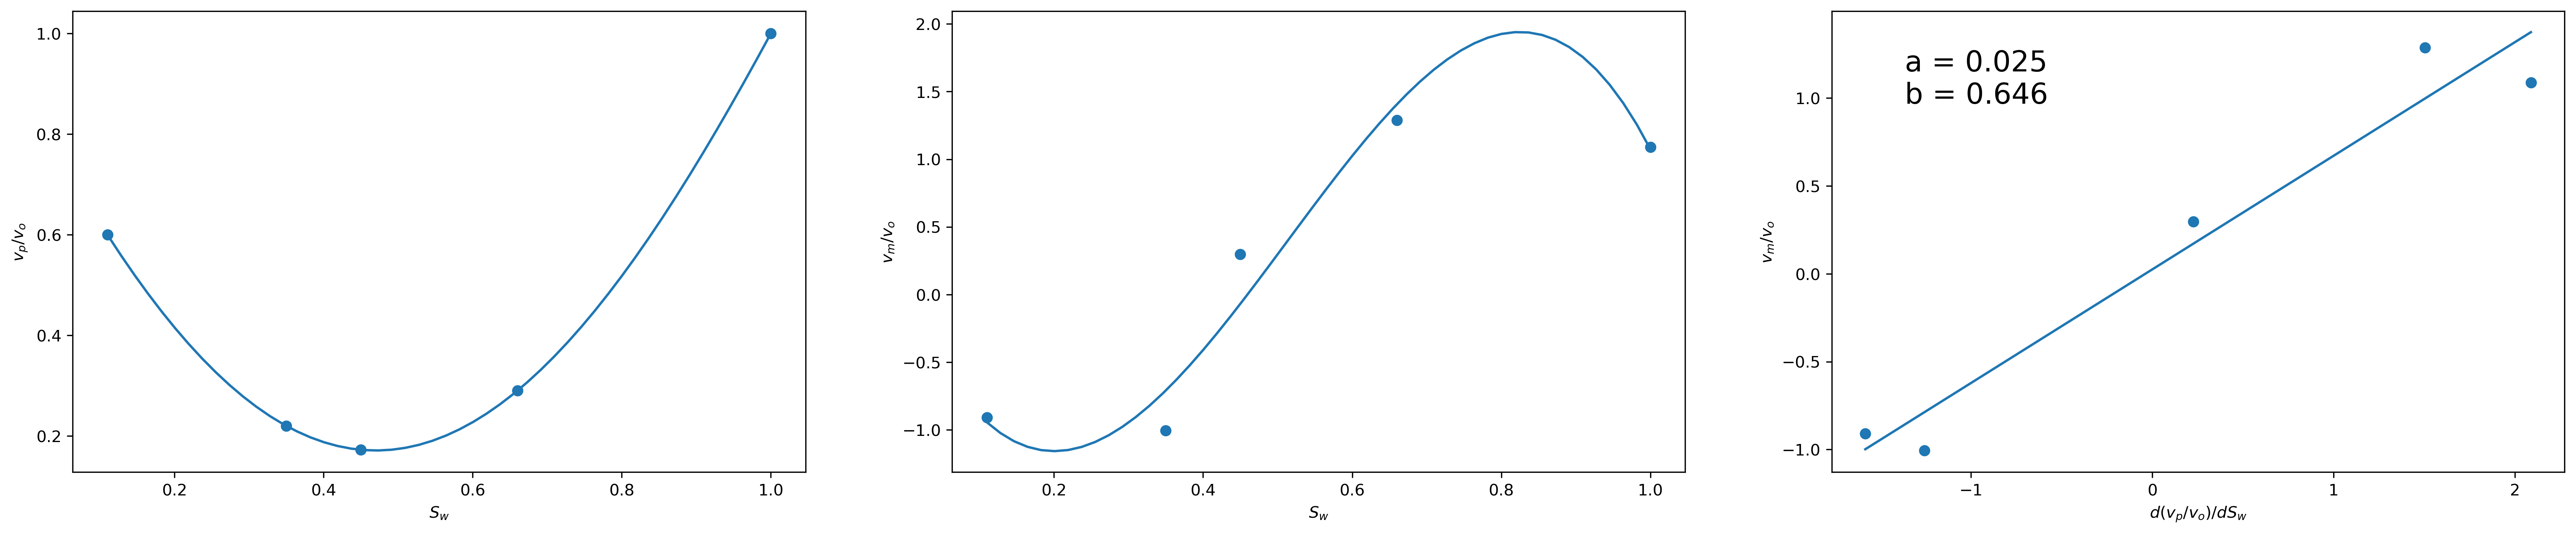

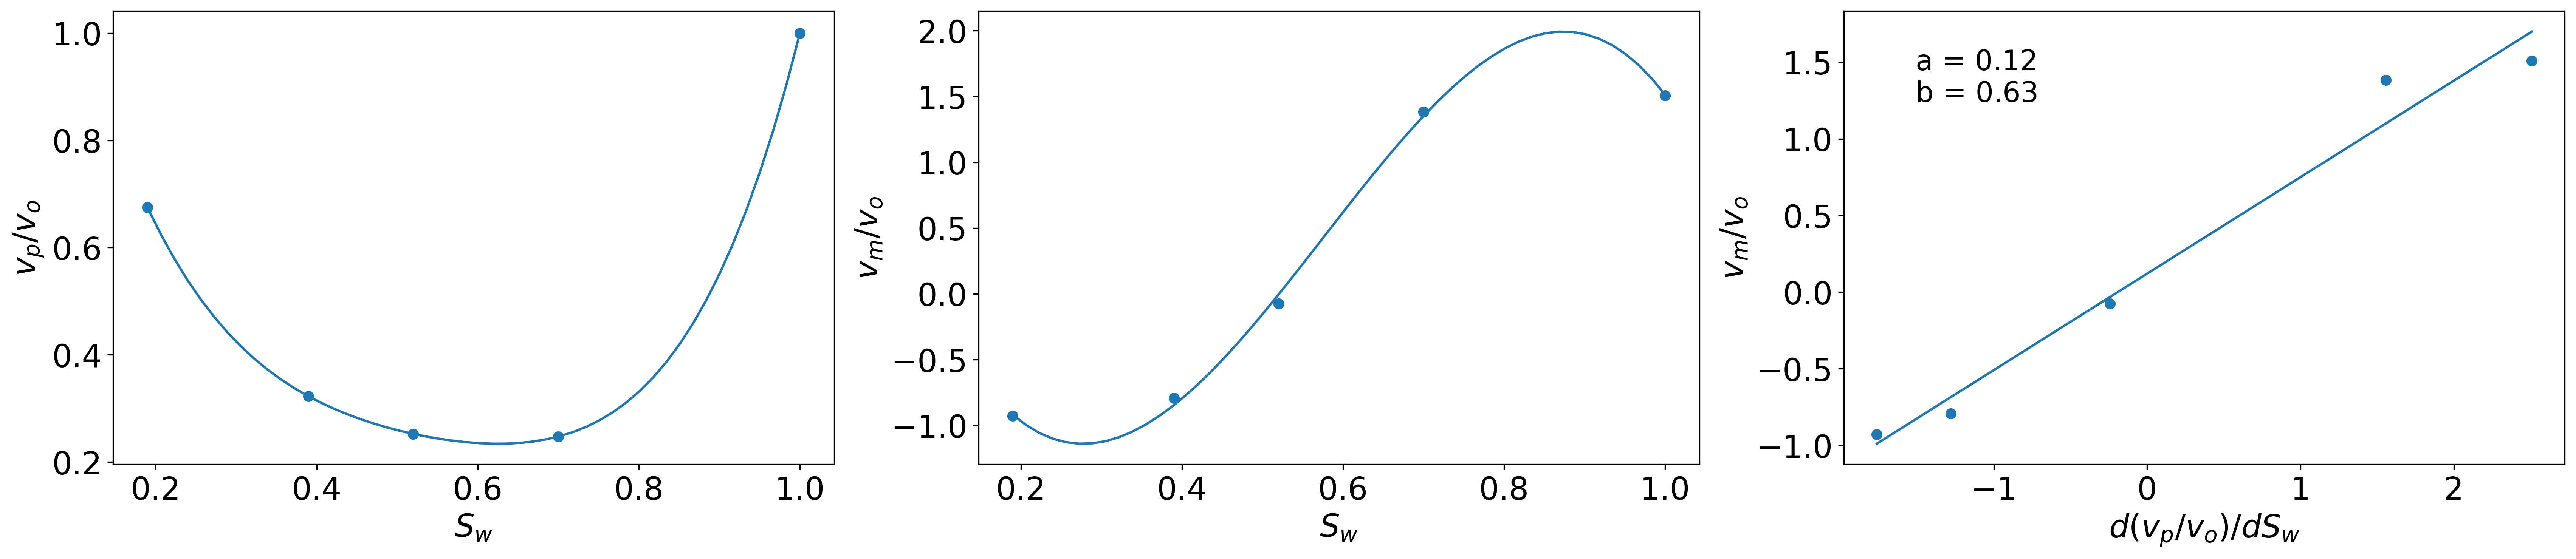

In [6]:
def fit_line(x,y, degree):
    z = np.polyfit(x, y, degree)
    f = np.poly1d(z)
    # calculate new x's and y's
    x_new = np.linspace(min(x), max(x), 50)
    y_new = f(x_new)
    return(x_new, y_new, f)

x_all1 = []
y_all1 = []
x_all2 = []
y_all2 = []
x_all3 = []
y_all3 = []
w_all = []

a = []
b = []
for k, case in enumerate (cases):
    
    plt.figure(k+1, figsize=(23,5), dpi=300)
    plt.subplot(1,3,1)
    plt.scatter(case['sw'], case['vp_vo'])
    x_new1, y_new1, _ = fit_line(case['sw'], case['vp_vo'],4)
    plt.plot(x_new1, y_new1)
    plt.xlabel('${S_w}$'), plt.ylabel('${v_p}/{v_o}$')
    #plt.title(' Wettability: '+case['wet_case'], fontsize =16)
    
    plt.subplot(1,3,2)
    plt.scatter(case['sw'], case['vm_vo'])
    x_new2, y_new2, _ = fit_line(case['sw'], case['vm_vo'],3)
    plt.plot(x_new2, y_new2 )
    plt.xlabel('${S_w}$'), plt.ylabel('${v_m}/{v_o}$')
    
    ax = plt.subplot(1,3,3)
    plt.scatter(case['d_vp_vo_dsw'], case['vm_vo'])
    x_new3, y_new3, f = fit_line(case['d_vp_vo_dsw'], case['vm_vo'],1)
    a.append(f[0])
    b.append(f[1])
    plt.plot(x_new3, y_new3 )
    t = 'a = '+str(round(f[0],3))+'\nb = '+str(round(f[1],3))
    plt.text(0.1, 0.8, t, fontsize =18, transform=ax.transAxes)
    plt.xlabel('$d({v_p}/{v_o})/{dS_w}$'), plt.ylabel('${v_m}/{v_o}$')
    plt.rcParams.update({'font.size': 20})
    plt.subplots_adjust(left=0.05,
                    bottom=0.15, 
                    right=0.99, 
                    top=0.95, 
                    wspace=0.2, 
                    hspace=0.1)
    #plt.savefig(os.path.join('./figures/exp/', case['wet_case']+'.png'))
    x_all3.extend(x_new3)
    y_all3.extend(y_new3)
    w_all.extend([case['w'] for i in range (len(x_new1))])
    x_all1.extend(x_new1)
    y_all1.extend(y_new1)
    x_all2.extend(x_new2)
    y_all2.extend(y_new2)

<ipython-input-7-83be1460d9e3>:12: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,3,1)
<ipython-input-7-83be1460d9e3>:18: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  plt.subplot(1,3,2)
<ipython-input-7-83be1460d9e3>:24: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and retur

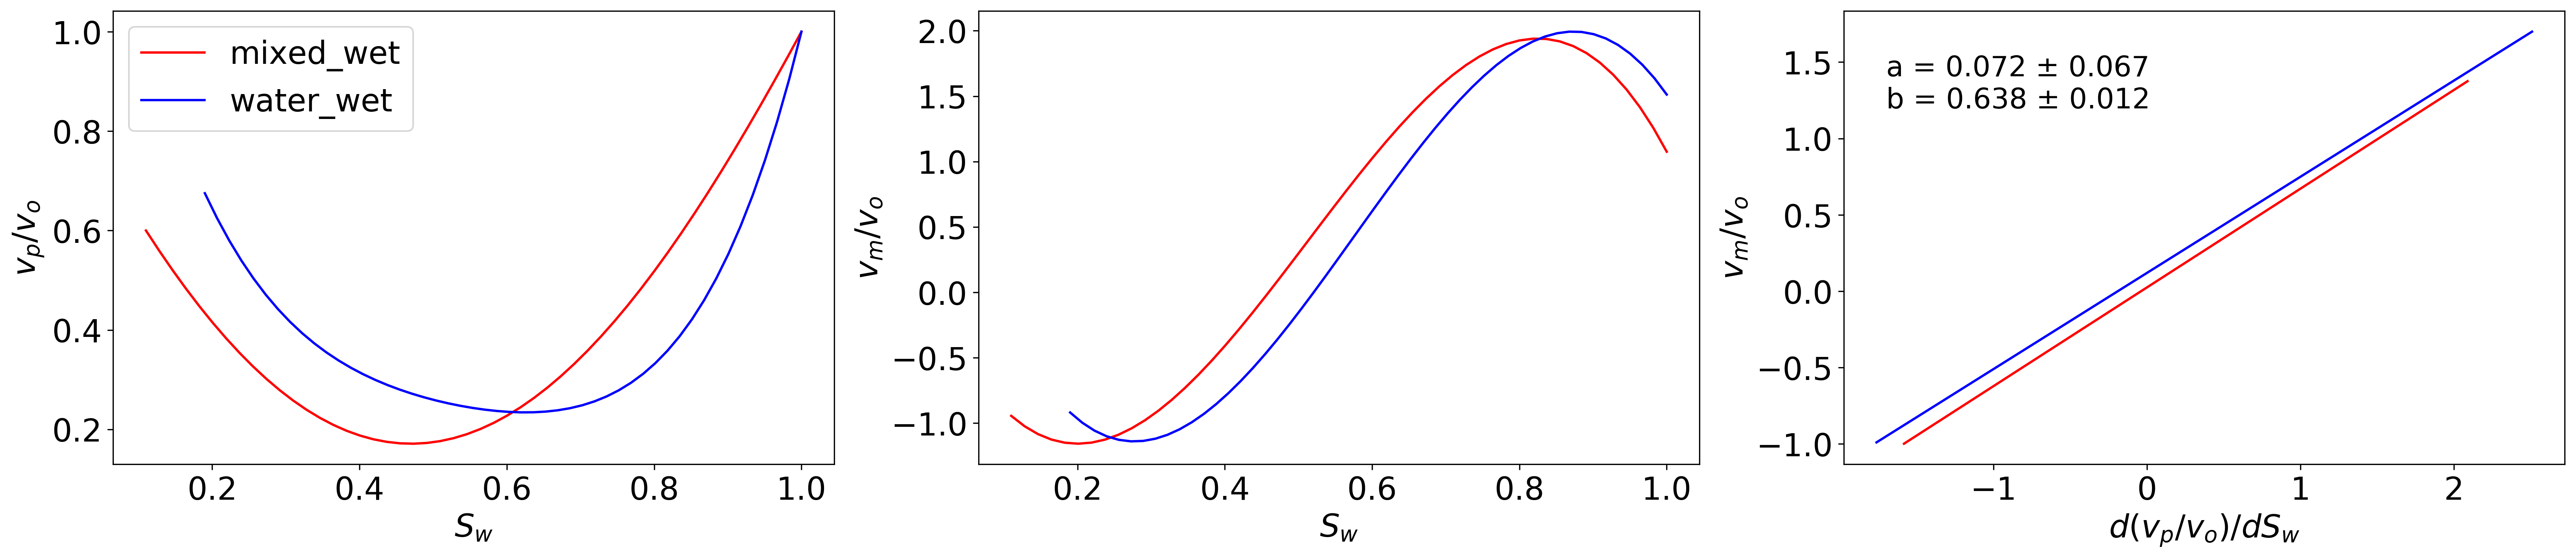

In [7]:
import statistics as stat

a_avg = round(stat.mean(a),3)
a_std = round(stat.stdev(a),3)
b_avg = round(stat.mean(b),3)
b_std = round(stat.stdev(b),3)

for k, case in enumerate (cases):
    if case['wet_case'] == 'water_wet': color = 'blue'
    else : color = 'red' 
    plt.figure(1, figsize=(23,5), dpi=300)
    plt.subplot(1,3,1)
    #plt.scatter(case['sw'], case['vp_vo'], color=color)
    x_new1, y_new1, _ = fit_line(case['sw'], case['vp_vo'],4)
    plt.plot(x_new1, y_new1, color=color, label=case['wet_case'])
    plt.xlabel('${S_w}$'), plt.ylabel('${v_p}/{v_o}$')
    plt.legend()
    plt.subplot(1,3,2)
    #plt.scatter(case['sw'], case['vm_vo'], color=color)
    x_new2, y_new2, _ = fit_line(case['sw'], case['vm_vo'],3)
    plt.plot(x_new2, y_new2, color=color)
    plt.xlabel('${S_w}$'), plt.ylabel('${v_m}/{v_o}$')
    
    plt.subplot(1,3,3)
    #plt.scatter(case['d_vp_vo_dsw'], case['vm_vo'], color=color)
    x_new3, y_new3, f = fit_line(case['d_vp_vo_dsw'], case['vm_vo'],1)
    a.append(f[0])
    b.append(f[1])
    plt.plot(x_new3, y_new3, color=color)
    #pos1, pos2 = sorted(case['d_vp_vo_dsw'])[0], 0.6#sorted(case['vm_vo'])[-2]
    #pos1, pos2 = sorted(cases['d_vp_vo_dsw'])[0], sorted(cases['vm_vo'])[-4]
    if k>0: 
        t = 'a = '+str(a_avg) +' \u00b1 '+ str(a_std)+'\nb = '+str(b_avg) +' \u00b1 '+ str(b_std)
        plt.text(-1.7, 1.2, t, fontsize =18)
        #plt.text(pos1+, pos2, str(a_avg) +' \u00b1 '+ str(a_std), fontsize =16)
    plt.xlabel('$d({v_p}/{v_o})/{dS_w}$'), plt.ylabel('${v_m}/{v_o}$')

    plt.rcParams.update({'font.size': 20})
    plt.subplots_adjust(left=0.05,
                bottom=0.15, 
                right=0.99, 
                top=0.95, 
                wspace=0.2, 
                hspace=0.1)
    #plt.savefig(os.path.join('./figures/exp/', 'Exp.png'))
